In [1]:
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Input, Conv2D, concatenate, GlobalAveragePooling2D, Dense, MaxPooling2D
from tensorflow.keras.optimizers import Adam
import keras.backend as K
import os
import numpy as np
import shutil
import tensorflow as tf
from tensorflow.keras.metrics import Metric

2024-03-12 13:44:42.186064: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-12 13:44:44.977579: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
train_dir=r'data/split_dataset/train'
test_dir=r'data/split_dataset/test'

In [3]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.15, 
    fill_mode='nearest'
)
test_datagen = ImageDataGenerator(rescale=1.0/255)


train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'  
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation' 
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 18741 images belonging to 2 classes.
Found 3306 images belonging to 2 classes.
Found 5511 images belonging to 2 classes.


In [4]:
x_train, y_train = train_generator.next()
x_test, y_test = test_generator.next()

In [5]:
from keras.layers import Input, Conv2D, concatenate, GlobalAveragePooling2D, Dense, MaxPooling2D, BatchNormalization, Activation
from keras.models import Model

def inception_resnet_block(x, filters):
    # 分支 1：1x1 卷积
    branch1 = Conv2D(filters, (1, 1), padding='same', use_bias=False)(x)
    branch1 = BatchNormalization()(branch1)
    branch1 = Activation('relu')(branch1)

    # 分支 2：1x1 卷积后接 3x3 卷积
    branch2 = Conv2D(filters, (1, 1), padding='same', use_bias=False)(x)
    branch2 = BatchNormalization()(branch2)
    branch2 = Activation('relu')(branch2)
    branch2 = Conv2D(filters, (3, 3), padding='same', use_bias=False)(branch2)
    branch2 = BatchNormalization()(branch2)
    branch2 = Activation('relu')(branch2)

    # 分支 3：1x1 卷积后接两个 3x3 卷积
    branch3 = Conv2D(filters, (1, 1), padding='same', use_bias=False)(x)
    branch3 = BatchNormalization()(branch3)
    branch3 = Activation('relu')(branch3)
    branch3 = Conv2D(filters, (3, 3), padding='same', use_bias=False)(branch3)
    branch3 = BatchNormalization()(branch3)
    branch3 = Activation('relu')(branch3)
    branch3 = Conv2D(filters, (3, 3), padding='same', use_bias=False)(branch3)
    branch3 = BatchNormalization()(branch3)
    branch3 = Activation('relu')(branch3)

    # 合并分支
    mixed = concatenate([branch1, branch2, branch3], axis=-1)

    # 残差连接
    up = Conv2D(x.shape[-1], (1, 1), padding='same', use_bias=False)(mixed)
    up = BatchNormalization()(up)
    x = concatenate([x, up])
    x = Activation('relu')(x)

    return x

def inception_resnet(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    # 初始卷积层
    x = Conv2D(32, (3, 3), strides=(2, 2), padding='same', use_bias=False)(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(32, (3, 3), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(64, (3, 3), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2))(x)

    # Inception-ResNet 块
    for _ in range(5):
        x = inception_resnet_block(x, 32)

    # 全局平均池化和分类层
    x = GlobalAveragePooling2D()(x)
    x = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=x)
    return model


In [6]:
input_shape = (224, 224, 3)  # Example input shape, adjust based on your requirements
num_classes = 2  # Adjust based on your classification task

In [7]:
model = inception_resnet(input_shape, num_classes)

2024-03-12 13:45:56.708218: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-12 13:45:56.858665: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-12 13:45:56.859087: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [8]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [9]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 112, 112, 32)         128       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 112, 112, 32)         0         ['batch_normalization[0][0

In [10]:
history = model.fit(train_generator, validation_data = validation_generator, epochs=30)

Epoch 1/30


2024-03-12 13:47:18.395262: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2024-03-12 13:47:24.148108: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-03-12 13:47:24.401170: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x1ced7c60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-12 13:47:24.401244: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2024-03-12 13:47:24.558675: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-03-12 13:47:25.325275: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the proce

586/586 [==============================] - 273s 413ms/step - loss: 0.2738 - accuracy: 0.8991 - val_loss: 0.2697 - val_accuracy: 0.8884
Epoch 2/30
586/586 [==============================] - 247s 420ms/step - loss: 0.2232 - accuracy: 0.9248 - val_loss: 0.2640 - val_accuracy: 0.8962
Epoch 3/30
586/586 [==============================] - 244s 416ms/step - loss: 0.2117 - accuracy: 0.9292 - val_loss: 0.2697 - val_accuracy: 0.8962
Epoch 4/30
586/586 [==============================] - 241s 411ms/step - loss: 0.1959 - accuracy: 0.9334 - val_loss: 0.2513 - val_accuracy: 0.9008
Epoch 5/30
586/586 [==============================] - 238s 406ms/step - loss: 0.1912 - accuracy: 0.9352 - val_loss: 0.3007 - val_accuracy: 0.8811
Epoch 6/30
586/586 [==============================] - 243s 414ms/step - loss: 0.1803 - accuracy: 0.9409 - val_loss: 0.2107 - val_accuracy: 0.9277
Epoch 7/30
586/586 [==============================] - 245s 417ms/step - loss: 0.1782 - accuracy: 0.9409 - val_loss: 0.2570 - val_accura

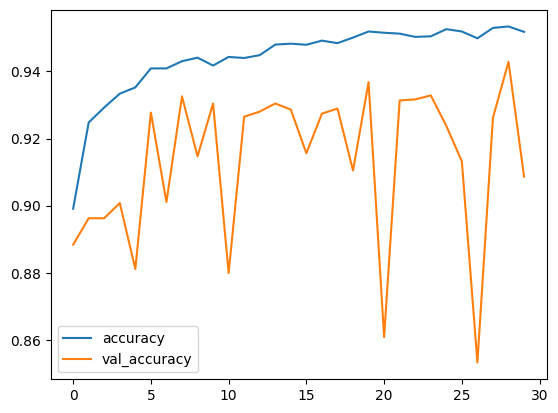

In [11]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

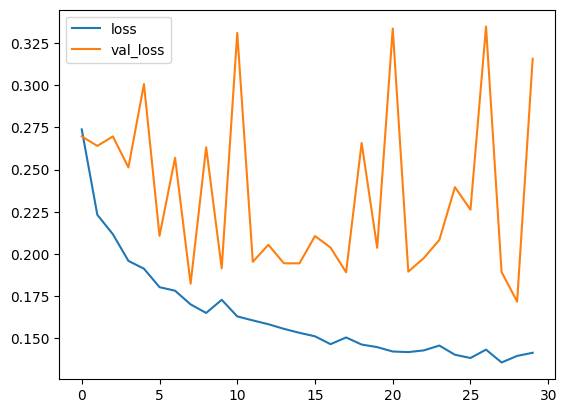

In [12]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

In [13]:
test_loss_ensemble, test_acc_ensemble = model.evaluate(test_generator)
print("Ensemble Test accuracy:", test_acc_ensemble)
print("Ensemble Test loss:", test_loss_ensemble)

173/173 [==============================] - 11s 64ms/step - loss: 0.2382 - accuracy: 0.9222
Ensemble Test accuracy: 0.9221556782722473
Ensemble Test loss: 0.23822739720344543


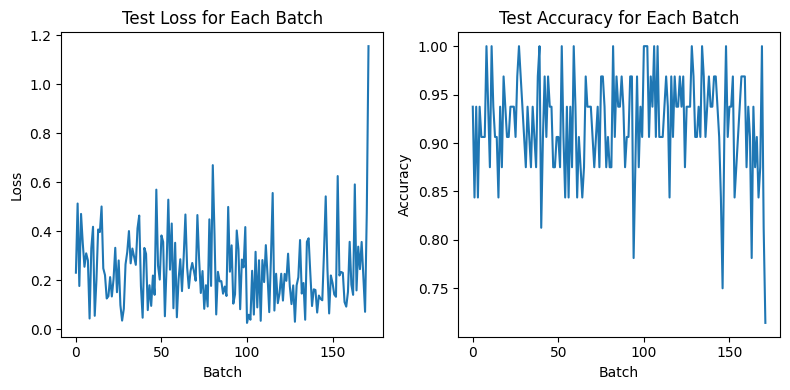

In [14]:
import matplotlib.pyplot as plt

test_steps = test_generator.n // test_generator.batch_size
batch_losses = []
batch_accuracies = []

# 遍历测试集的每个批次
for _ in range(test_steps):
    x, y = test_generator.next()
    loss, acc = model.evaluate(x, y, verbose=0)
    batch_losses.append(loss)
    batch_accuracies.append(acc)

# 绘制批次损失图表
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(range(test_steps), batch_losses, label='Batch Loss')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.title('Test Loss for Each Batch')

# 绘制批次准确率图表
plt.subplot(1, 2, 2)
plt.plot(range(test_steps), batch_accuracies, label='Batch Accuracy')
plt.xlabel('Batch')
plt.ylabel('Accuracy')
plt.title('Test Accuracy for Each Batch')

plt.tight_layout()
plt.show()

In [15]:
from sklearn.metrics import confusion_matrix
import numpy as np

# 收集测试数据的真实标签和预测值
test_steps = test_generator.n // test_generator.batch_size
y_true = []
y_pred = []

for _ in range(test_steps):
    x, y = test_generator.next()
    predictions = model.predict(x)
    y_true.extend(np.argmax(y, axis=1))
    y_pred.extend(np.argmax(predictions, axis=1))

# 生成混淆矩阵
cm = confusion_matrix(y_true, y_pred)

# 计算TP, TN, FP, FN
TP = cm[1, 1]
TN = cm[0, 0]
FP = cm[0, 1]
FN = cm[1, 0]

# 计算灵敏度和特异性
sensitivity = TP / float(TP + FN)
specificity = TN / float(TN + FP)

print(f'Sensitivity: {sensitivity}')
print(f'Specificity: {specificity}')

1/1 [==============================] - 0s 41ms/step
Sensitivity: 0.9894545454545455
Specificity: 0.8547567175018156


In [16]:
from tensorflow.keras.layers import Input, Dense, concatenate
from tensorflow.keras.models import Model
from sklearn.metrics import precision_score, recall_score
import numpy as np
# 收集测试数据和标签
test_steps = test_generator.n // test_generator.batch_size
y_test_all = np.array([])
preds_all = np.array([])

for _ in range(test_steps):
    x_test, y_test = test_generator.next()
    preds = model.predict(x_test)

    y_test_all = np.append(y_test_all, np.argmax(y_test, axis=1))
    preds_all = np.append(preds_all, np.argmax(preds, axis=1))

# 计算精确度和召回率
precision = precision_score(y_test_all, preds_all)
recall = recall_score(y_test_all, preds_all)

print(f'Precision: {precision}')
print(f'Recall: {recall}')

1/1 [==============================] - 0s 33ms/step
Precision: 0.8717041800643087
Recall: 0.9894160583941606


In [17]:
from sklearn.metrics import f1_score
import numpy as np

# 收集测试数据的真实标签和预测值
test_steps = test_generator.n // test_generator.batch_size
y_true = []
y_pred = []

for _ in range(test_steps):
    x, y = test_generator.next()
    predictions = model.predict(x)
    y_true.extend(np.argmax(y, axis=1))
    y_pred.extend(np.argmax(predictions, axis=1))

# 计算F1分数
f1 = f1_score(y_true, y_pred, average='binary')  # 对于二分类问题

print(f'F1 Score: {f1}')

1/1 [==============================] - 0s 39ms/step
F1 Score: 0.9272540983606558


1/1 [==============================] - 0s 34ms/step
Confusion matrix, without normalization
Normalized confusion matrix


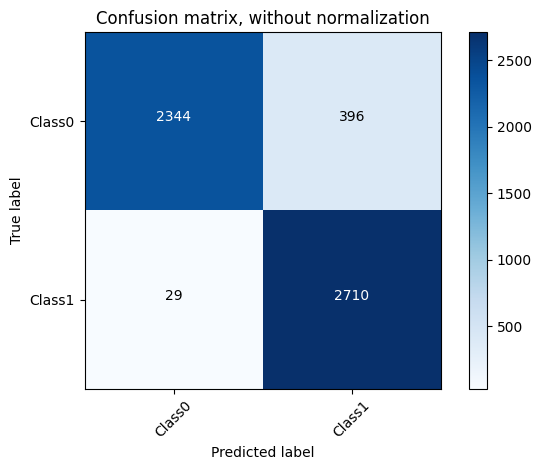

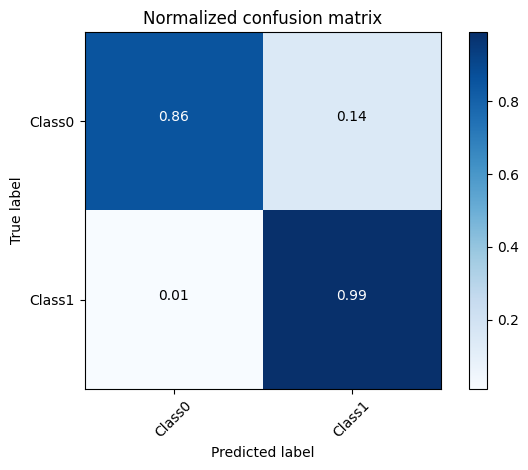

In [18]:
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import itertools

# 假设您的模型是 combined
# 假设您的测试数据生成器是 test_generator

# 收集测试数据的真实标签和预测值
test_steps = test_generator.n // test_generator.batch_size
y_true = []
y_pred = []

for _ in range(test_steps):
    x, y = test_generator.next()
    predictions = model.predict(x)
    y_true.extend(np.argmax(y, axis=1))
    y_pred.extend(np.argmax(predictions, axis=1))

# 生成混淆矩阵
cm = confusion_matrix(y_true, y_pred)

# 绘制混淆矩阵
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    这个函数打印并绘制混淆矩阵。
    可以通过设置 `normalize=True` 来应用归一化。
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# 类别名称
class_names = ['Class0', 'Class1']  # 根据您的数据集调整

# 绘制非归一化的混淆矩阵
plt.figure()
plot_confusion_matrix(cm, classes=class_names, title='Confusion matrix, without normalization')

# 绘制归一化的混淆矩阵
plt.figure()
plot_confusion_matrix(cm, classes=class_names, normalize=True, title='Normalized confusion matrix')

plt.show()

1/1 [==============================] - 0s 35ms/step


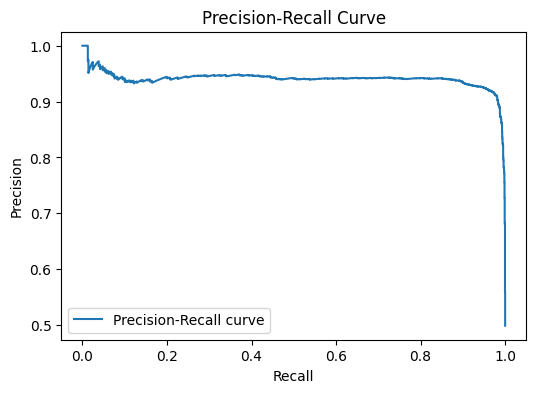

In [19]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
import numpy as np

# 收集测试数据的真实标签和预测值
test_steps = test_generator.n // test_generator.batch_size
y_true = np.array([])
y_scores = np.array([])

for _ in range(test_steps):
    x, y = test_generator.next()
    predictions = model.predict(x)
    y_true = np.append(y_true, np.argmax(y, axis=1))
    y_scores = np.append(y_scores, predictions[:, 1])  # 假设第二列为阳性类别的预测概率

# 计算精确度和召回率
precision, recall, thresholds = precision_recall_curve(y_true, y_scores)

# 绘制精确度-召回率曲线
plt.figure(figsize=(6, 4))
plt.plot(recall, precision, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

1/1 [==============================] - 0s 33ms/step


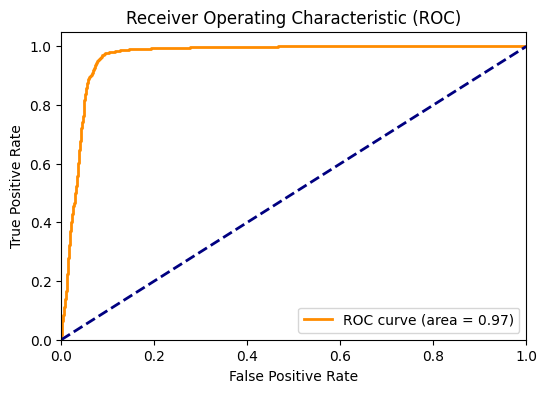

In [20]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# 收集测试数据的真实标签和预测值
test_steps = test_generator.n // test_generator.batch_size
y_true = np.array([])
y_scores = np.array([])

for _ in range(test_steps):
    x, y = test_generator.next()
    predictions = model.predict(x)
    y_true = np.append(y_true, np.argmax(y, axis=1))
    y_scores = np.append(y_scores, predictions[:, 1])  # 假设第二列为阳性类别的预测概率

# 计算ROC曲线的参数
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

# 绘制ROC曲线
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()